In [96]:
from pathlib import Path
import pandas as pd

!pwd

/home/dek/gitroot/phd/oe-dimensionality/notebooks-legacy


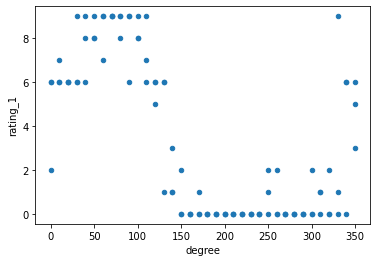

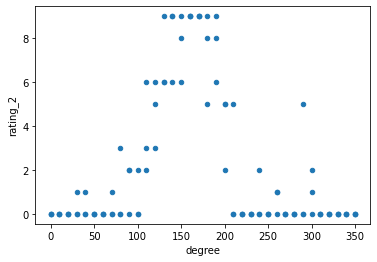

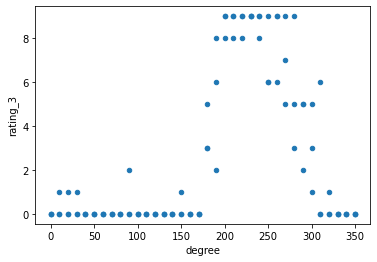

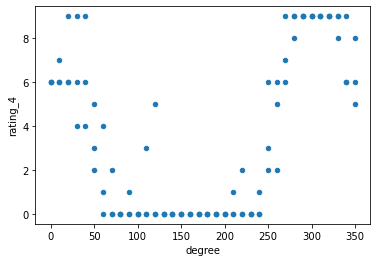

In [97]:
subject = 'AV11'
# condition = 'intermediates'
condition = 'unique'
data_root = Path('../data/raw/bosten_boehm_2011_hue')
df = pd.read_csv(data_root / f'{subject}1session1{condition}ratingtable.txt', sep='\t',
                 index_col=False, names=['degree', 'rating_1', 'rating_2', 'rating_3', 'rating_4', 'RT'])

for c in df.columns:
    if c.startswith('rating_'):
        df.plot(x='degree', y=c, kind='scatter')

The columns are ordered RED, YELLOW, GREEN, BLUE


In [98]:
import numpy as np
from cblearn import datasets, embedding, utils
from sklearn.metrics.pairwise import paired_distances
import matplotlib.pyplot as plt



def sample_rating_triplets(df, n_triplets, metric='euclidean'):
    target_colors = df.degree.unique()
    target_colors.sort()
    triplets = datasets.make_random_triplet_indices(size=n_triplets, n_objects=len(target_colors))

    ratings = df.set_index('degree').drop('RT', 'columns')
    rating_triplets = np.empty(shape=(*triplets.shape, 4))
    for row in range(len(triplets)):
        for col in range(3):
            rating_triplets[row, col, :] = ratings.loc[target_colors[triplets[row, col]]].sample(n=1)

    near = paired_distances(rating_triplets[:, 0], rating_triplets[:, 1], metric)
    far = paired_distances(rating_triplets[:, 0], rating_triplets[:, 2], metric)
    responses = near <= far
    return utils.check_query_response(triplets, responses, result_format='list-order')


test_triplets = sample_rating_triplets(df, 10000)

/home/dek/anaconda3/envs/oe-dimensionality/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass metric=euclidean as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/dek/anaconda3/envs/oe-dimensionality/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass metric=euclidean as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


/home/dek/anaconda3/envs/oe-dimensionality/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass metric=euclidean as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/dek/anaconda3/envs/oe-dimensionality/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass metric=euclidean as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


(0.996, 0.7619)

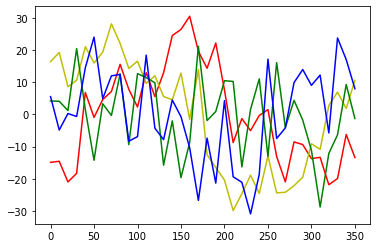

In [99]:
triplets = sample_rating_triplets(df, 500)
soe = embedding.SOE(4)
embedding_4d = soe.fit_transform(triplets)

target_colors = df.degree.unique()
target_colors.sort()
if condition == 'unique':
    colors = ['r', 'y', 'g', 'b']
elif condition == 'intermediates':
    colors = ['orange', 'lime', 'teal', 'purple']
else:
    raise NotImplemented

for primary, color in zip(embedding_4d.T, colors):
    plt.plot(target_colors, primary, color=color)

soe.score(triplets), soe.score(test_triplets)

In [100]:
from matplotlib.colors import hsv_to_rgb

def plot_colors(embedding_2d):
    target_colors = df.degree.unique()
    target_colors.sort()
    target_hsv = np.c_[target_colors / 360, np.ones_like(target_colors), np.ones_like(target_colors)]
    target_rgb = hsv_to_rgb(target_hsv)
    plt.scatter(*embedding_2d.T, c=target_rgb)

/home/dek/anaconda3/envs/oe-dimensionality/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass metric=euclidean as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/dek/anaconda3/envs/oe-dimensionality/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass metric=euclidean as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


(0.878, 0.8388)

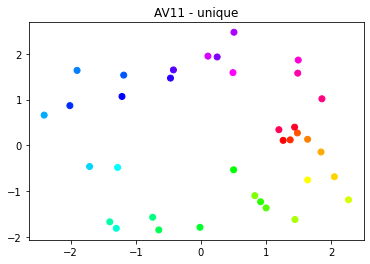

In [101]:
triplets = sample_rating_triplets(df, 1000)
soe = embedding.SOE(2)
embedding_2d = soe.fit_transform(triplets)

plot_colors(embedding_2d)
plt.title(f'{subject} - {condition}')
plt.savefig(f'../tex/plots/colorwheel_bostenboehm_{subject}_{condition}.pdf')


soe.score(triplets), soe.score(test_triplets)

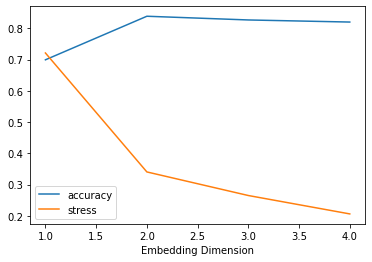

In [114]:
dims = [1, 2, 3, 4]
soes = [embedding.SOE(dim).fit(triplets) for dim in dims]
plt.plot(dims, [soe.score(test_triplets) for soe in soes], label='accuracy')
plt.plot(dims, [soe.stress_ / len(triplets) for soe in soes], label='stress')
plt.xlabel('Embedding Dimension')
plt.legend()


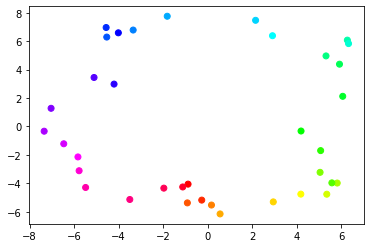

Text(0, 0.5, 'Stress')

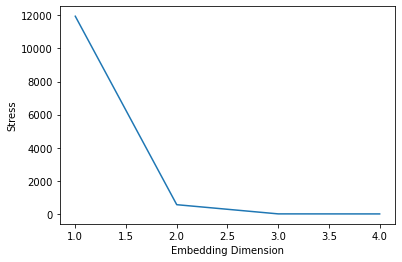

In [110]:
from sklearn.manifold import MDS


mean_ratings = df.groupby('degree').mean().filter(like='rating', axis='columns').values
mds = MDS(2)
plot_colors(mds.fit_transform(mean_ratings))
plt.show()

plt.plot(dims, [MDS(dim).fit(mean_ratings).stress_ for dim in dims])
plt.xlabel('Embedding Dimension')
plt.ylabel('Stress')
